# The Stanford Question Answering Dataset

Consists of a Question-Answering Dataset, and a reference text is provided to each of the topics to also feed into the training process.

Example: https://rajpurkar.github.io/SQuAD-explorer/explore/1.1/dev/Nikola_Tesla.html

For each question, there are ground truth answers, which are passages from the reference text and the model prediction.

## Bert Structure

Bert has 24 layers and an embedding size of `1024` for a total of 340 million parameters! This all together results in a size of 1,34GB.

The final embedding will be multiplied by the start weight factor of the input and a soft-max function $\frac{e^x}{\sum e^x}$ is applied on this output. This process is also applied of the end weight factor.


In [1]:
# !pip install transformers

## Import PyTorch

In [2]:
import torch
from bert_utils import BertUtils

In [3]:
from transformers import BertForQuestionAnswering

pretrained_model_name: str = 'bert-large-uncased-whole-word-masking-finetuned-squad'

model = BertForQuestionAnswering.from_pretrained(pretrained_model_name)

In [4]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)

In [5]:
bert_utils = BertUtils(model, tokenizer)

## Ask a Question

A Question-Answer sample consists of a question and a text passage containing the answer to that question.

In the following example, the answer should be 340M.

In [6]:
question: str = 'When did Tesla discover the possibility of wireless connectivity?'
answer_text: str = 'Tesla went on to pursue his ideas of wireless lighting and electricity distribution in his high-voltage, high-frequency power experiments in New York and Colorado Springs, and made early (1893) pronouncements on the possibility of wireless communication with his devices. He tried to put these ideas to practical use in an ill-fated attempt at intercontinental wireless transmission, his unfinished Wardenclyffe Tower project. In his lab he also conducted a range of experiments with mechanical oscillators/generators, electrical discharge tubes, and early X-ray imaging. He also built a wireless controlled boat, one of the first ever exhibited.'

BERT tokenizer has to be run against both the `question` and the `answer_text`.
These variables are first concatenated with a `[SEP]` token as delimiter between them and then fed into BERT.

In [7]:
# Apply the tokenizer to the input text, threating them as a text-pair
input_ids = tokenizer.encode(question, answer_text)

print(f'The input has a total of {len(input_ids)} tokens.')

The input has a total of 138 tokens.


In [8]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)

for token, id in zip(tokens, input_ids):

    if id == tokenizer.sep_token_id:
        print('')

    print(f'{token:<12} {id:>6,}')

    if id == tokenizer.sep_token_id:
        print('')

[CLS]           101
when          2,043
did           2,106
tesla        26,060
discover      7,523
the           1,996
possibility   6,061
of            1,997
wireless      9,949
connectivity 20,831
?             1,029

[SEP]           102

tesla        26,060
went          2,253
on            2,006
to            2,000
pursue        7,323
his           2,010
ideas         4,784
of            1,997
wireless      9,949
lighting      7,497
and           1,998
electricity   6,451
distribution  4,353
in            1,999
his           2,010
high          2,152
-             1,011
voltage      10,004
,             1,010
high          2,152
-             1,011
frequency     6,075
power         2,373
experiments   7,885
in            1,999
new           2,047
york          2,259
and           1,998
colorado      5,169
springs       6,076
,             1,010
and           1,998
made          2,081
early         2,220
(             1,006
1893          6,489
)             1,007
pro           4,01

In [9]:
# Search the input_ids for the first instance of the `[SEP]` token
sep_index = input_ids.index(tokenizer.sep_token_id)

# The number of segment A tokens includes the [SEP] token itself
num_seq_a = sep_index + 1

# the remainder are segment B
num_seq_b = len(input_ids) - num_seq_a

# Construct the list of 0s and 1s
segment_ids = [0] * num_seq_a + [1] * num_seq_b

# There should be a segment_id for every input token
assert len(segment_ids) == len(input_ids)

In [10]:
outputs = model(torch.tensor([input_ids]), # the tokens representing our input text
                             token_type_ids=torch.tensor([segment_ids]), # The segment IDs to differentiate question from answer_text
                             return_dict=True)

start_scores = outputs.start_logits
end_scores = outputs.end_logits

### Highlight the answer by looking at the most probable start and end words


In [11]:
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

answer = ' '.join(tokens[answer_start:answer_end+1])

print(f"Answer: '{answer}'")

Answer: <1893>


In [12]:
answer = bert_utils.get_answer_to_question(question, answer_text)
print(f"Answer: '{answer}'")

Answer: <1893>


In [13]:
# Start with the first token
answer = tokens[answer_start]

# Select remaining answer tokens and join them with whitespace
for idx in range(answer_start + 1, answer_end + 1):

    # If it's a subword token, then recombine it with the previous token
    if tokens[idx][0:2] == '##':
        answer += tokens[idx][2:]

    # Otherwise add a space then the token
    else:
        answer += f' {tokens[idx]}' 

print(f"Answer: '{answer}'")

Answer: '1893'


### Visualizing Scores

Generate bar plots that show the start and end scores for every word in the input.

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn
sns.set(style='darkgrid')

# Increase the plot size and font size
plt.rcParams['figure.figsize'] = (16, 8)

### Retrieving the start and end scores, use tokens as x-axis labels.

In [15]:
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# Use the tokens as the x-axis labels. In order to do that, they all need 
# to be unique, so the token index gets added to the end of each one
token_labels = []
for (idx, token) in enumerate(tokens):
    token_labels.append(f'{token:} - {idx:>2}')

#### Create a bar plot showing the score for every input word being the 'start' work

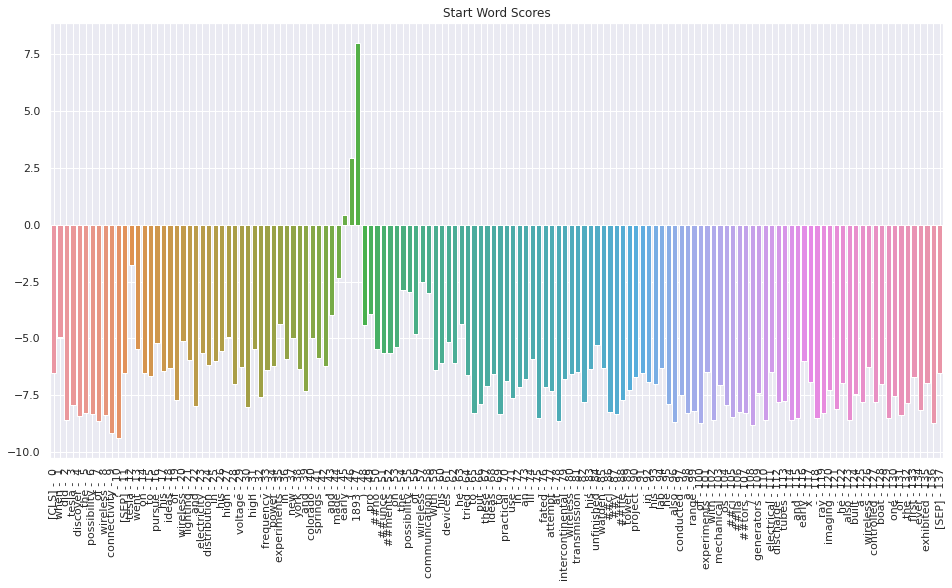

In [16]:
# Create a barplot showing the start word score for all of the tokens
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

# Turn on the vertical grid to help align words to scores
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

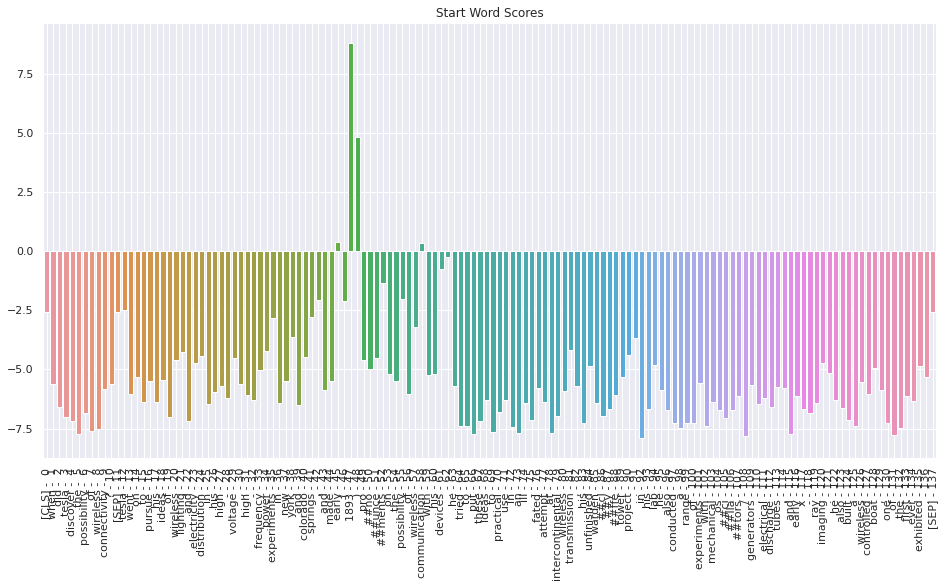

In [17]:
# Create a barplot showing the start word score for all of the tokens
ax = sns.barplot(x=token_labels, y=e_scores, ci=None)

# Turn the xlabels vertical
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')

# Turn on the vertical grid to help align words to scores
ax.grid(True)

plt.title('Start Word Scores')

plt.show()